In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
from torch import nn

In [3]:
import torchvision
import torchvision.transforms as T

In [4]:
transform = T.Compose([
    T.ToTensor(),
])

In [5]:
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [7]:
device

'mps'

In [8]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [9]:
import torch.nn.functional as F

In [10]:
input_dim = 28 ** 2
z_dim = 20
h_dim = 200

In [11]:
class AE(nn.Module):
    def __init__(self, input_dim, z_dim, h_dim):
        super().__init__()
        self.common = nn.Linear(input_dim, h_dim)
        self.encoded = nn.Linear(h_dim, z_dim)
        self.ll = nn.Linear(z_dim, h_dim)
        self.decoded = nn.Linear(h_dim, input_dim)
    def encoder(self, X):
        common = F.relu(self.common(X))
        mu = self.encoded(common)
        return mu

    def decoder(self, z):
        out = F.relu(self.ll(z))
        out = torch.sigmoid(self.decoded(out))
        return out

    def forward(self, X):
        mu = self.encoder(X)
        out = self.decoder(mu)
        return out, mu

In [12]:
model = AE(input_dim, z_dim, h_dim).to(device)

In [13]:
lr = .00025

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [15]:
idx = 0
origins = []
for img, label in test_set:
    if label == idx:
        origins.append(img)
        idx += 1
    if idx == 10:
        break

In [16]:
def plot_digits():
    reconstructed = []
    for idx in range(10):
        with torch.no_grad():
            img = origins[idx].reshape(1, input_dim)
            out, mu = model(img.to(device))
        reconstructed.append(out)
    imgs = origins + reconstructed
    plt.figure(figsize=(10, 2), dpi=50)
    for i in range(20):
        ax = plt.subplot(2,10, i + 1)
        img=(imgs[i]).detach().cpu().numpy()
        plt.imshow(img.reshape(28,28),
        cmap="binary")
        plt.xticks([])
        plt.yticks([])
    plt.show()

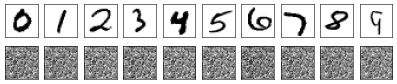

In [17]:
plot_digits()

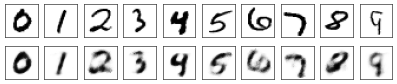

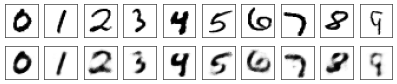

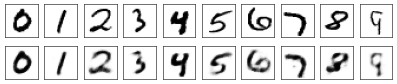

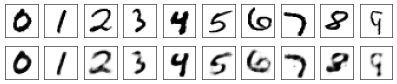

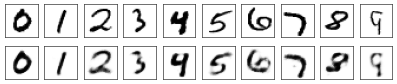

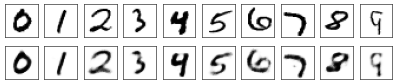

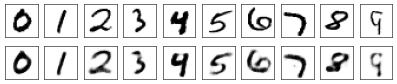

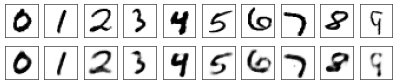

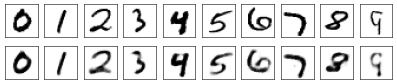

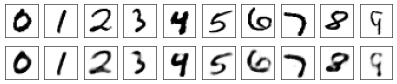

In [ ]:
from tqdm import tqdm
for epoch in range(10):
    tloss = 0
    loop = tqdm(train_loader, leave=False)
    for imgs, labels in loop:
        imgs = imgs.to(device).view(-1, input_dim)
        out, mu = model(imgs)
        loss = ((out - imgs) ** 2).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tloss += loss.item()
        loop.set_postfix(tloss=tloss)
    plot_digits()